In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import copy

# Preprocess

In [2]:
directory = './csvFiles'

In [3]:
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

In [4]:
# 파일 목록을 랜덤하게 섞습니다.
random.seed(42)  # 재현 가능한 결과를 위해 시드 설정
random.shuffle(csv_files)

In [5]:
df_list = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    df = df.iloc[300:-100]
    df = df.apply(lambda x: float(f"{x:.2f}") if isinstance(x, (int, float)) else x)
    df_list.append(df)

In [6]:
combined_df = pd.concat(df_list, ignore_index=True)

In [7]:
combined_df

,Frame,Time,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,...,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ,Unnamed: 128
0,301,3.454812,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.262754,352.2222,350.739100,0.733168,0.943708,0.631755,0.200809,359.55840,0.846429,NaN
1,302,3.465498,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.274371,352.2729,350.772300,0.733238,0.943977,0.631620,0.114945,359.53570,0.884086,NaN
2,303,3.476308,0.021056,0.537794,0.689871,358.82500,0.679502,359.8412,-0.037938,0.455332,...,8.273871,352.2918,350.806000,0.733297,0.944234,0.631682,0.151095,359.52710,0.923961,NaN
3,304,3.487449,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.267890,352.2754,350.814000,0.733297,0.944235,0.631826,0.239347,359.53850,0.959352,NaN
4,305,3.498579,0.021056,0.537794,0.689871,358.82500,0.679492,359.8412,-0.037938,0.455332,...,8.257694,352.2285,350.846900,0.733279,0.944438,0.631913,0.385812,359.57180,0.958712,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250226,4599,51.249270,-0.673822,0.459417,0.821094,18.55227,179.767100,357.6623,-0.613921,0.391424,...,11.127110,198.3036,3.762991,-1.322575,1.039530,0.926472,47.165740,37.40024,178.720300,NaN
1250227,4600,51.260610,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.131550,198.3722,3.791916,-1.323386,1.040075,0.924556,47.211770,37.32508,178.617100,NaN
1250228,4601,51.271360,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.133720,198.4202,3.836214,-1.323311,1.040272,0.924719,47.288450,37.23001,178.460700,NaN
1250229,4602,51.283000,-0.674628,0.459754,0.821685,18.35563,179.608500,357.6249,-0.614788,0.391658,...,11.135700,198.4699,3.866319,-1.323236,1.040406,0.924903,47.363370,37.13769,178.286900,NaN


In [8]:
len(combined_df)

1250231

In [9]:
rotation_columns = [col for col in combined_df.columns if 'Rot' in col]
rotation_df = combined_df[rotation_columns]

# -180~180 사이로 정규화
normalize_angle = lambda x: (x - 360) if x > 180 else (x + 360) if x < -180 else x
rotation_df = rotation_df.apply(lambda col: col.apply(normalize_angle))

In [10]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = (rotation_df > 180).sum().sum() + (rotation_df < -180).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

범위를 벗어나는 값이 없습니다.


In [11]:
rotation_df.to_csv('./rotation_df.csv', index=False)

# Transformer Learning

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm

In [13]:
# 변환된 데이터를 DataFrame으로 변환
rotation_df = pd.DataFrame(rotation_df, columns=rotation_df.columns)

In [14]:
rotation_df

,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipRotX,m_avg_L_HipRotY,m_avg_L_HipRotZ,m_avg_L_KneeRotX,m_avg_L_KneeRotY,m_avg_L_KneeRotZ,m_avg_L_AnkleRotX,...,m_avg_R_CollarRotZ,m_avg_R_ShoulderRotX,m_avg_R_ShoulderRotY,m_avg_R_ShoulderRotZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,-1.17500,0.679502,-0.1588,-0.2778,0.109241,-0.0179,-0.92970,0.176747,-0.0886,0.043651,...,1.795381,9.137008,-0.3370,-6.65920,8.262754,-7.7778,-9.260900,0.200809,-0.44160,0.846429
1,-1.17500,0.679502,-0.1588,-0.2778,0.109241,-0.0179,-0.92970,0.176747,-0.0886,0.043651,...,1.795381,9.137484,-0.3512,-6.63370,8.274371,-7.7271,-9.227700,0.114945,-0.46430,0.884086
2,-1.17500,0.679502,-0.1588,-0.2778,0.109241,-0.0179,-0.92970,0.176747,-0.0886,0.043651,...,1.795381,9.128529,-0.3738,-6.60920,8.273871,-7.7082,-9.194000,0.151095,-0.47290,0.923961
3,-1.17500,0.679492,-0.1588,-0.2778,0.109216,-0.0179,-0.92970,0.176716,-0.0886,0.043725,...,1.795413,9.122496,-0.3871,-6.61610,8.267890,-7.7246,-9.186000,0.239347,-0.46150,0.959352
4,-1.17500,0.679492,-0.1588,-0.2778,0.109216,-0.0179,-0.92970,0.176716,-0.0886,0.043725,...,1.795413,9.118235,-0.3485,-6.60340,8.257694,-7.7715,-9.153100,0.385812,-0.42820,0.958712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250226,18.55227,179.767100,-2.3377,-0.4977,178.544800,-15.6818,53.06687,167.804900,-10.1720,61.003280,...,22.802470,12.731160,-177.8204,15.82798,11.127110,-161.6964,3.762991,47.165740,37.40024,178.720300
1250227,18.35563,179.608500,-2.3751,-0.4831,178.673800,-15.7692,53.21533,167.780100,-10.3196,61.120850,...,21.790150,11.644520,-178.0025,15.93279,11.131550,-161.6278,3.791916,47.211770,37.32508,178.617100
1250228,18.35563,179.608500,-2.3751,-0.4831,178.673800,-15.7692,53.21533,167.780100,-10.3196,61.120850,...,21.790150,11.644520,-178.0025,15.93279,11.133720,-161.5798,3.836214,47.288450,37.23001,178.460700
1250229,18.35563,179.608500,-2.3751,-0.4831,178.673800,-15.7692,53.21533,167.780100,-10.3196,61.120850,...,21.790150,11.644520,-178.0025,15.93279,11.135700,-161.5301,3.866319,47.363370,37.13769,178.286900


In [15]:
train = rotation_df.iloc[:897757]
test = rotation_df.iloc[897757:]

In [16]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=42, shuffle=False)

In [17]:
batch_size = 128
n_input = 30  # Sequence length
n_features = 63  # Number of features
output_units = (21 * 3)  # Output shape
head_size = 256  # Size of attention head
num_heads = 7  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer
num_blocks = 4  # Number of transformer blocks
mlp_units = [512, 256, 128]  # Size of the dense layers of the final classifier
dropout_rate = 0.3 


In [18]:
class TimeseriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length] # : 입력 시퀀스 (30개의 데이터)
        y = self.data[index+self.sequence_length-1] # : 예측 시퀀스 (1개의 데이터)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

# 데이터셋과 데이터 로더를 생성
train_dataset = TimeseriesDataset(X_train.values, n_input)
val_dataset = TimeseriesDataset(X_val.values, n_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# 데이터 로더에서 첫 번째 배치를 가져와서 형태를 확인
first_batch = next(iter(train_loader))
X, y = first_batch

print("X batch shape:", X.shape)
print("y batch shape:", y.shape)

X batch shape: torch.Size([128, 30, 63])
y batch shape: torch.Size([128, 63])


### Transformer Model

In [20]:
# Positional Encoding 정의
class PositionalEncoding(nn.Module):
    def __init__(self, n_features, n_input):
        super(PositionalEncoding, self).__init__() # 상속받은 nn.Module 클래스의 __init__() 메서드 호출
        pe = torch.zeros(n_input, n_features) # 가장 큰 시퀀스 길이인 max_len을 기준으로 모두 0으로 채워진 크기가 (max_len, n_features)인 텐서 생성
        position = torch.arange(0, n_input, dtype=torch.float).unsqueeze(1) # position 텐서 생성

        # div_term을 계산하는 방식 수정
        div_term = torch.exp(torch.arange(0, n_features, 2).float() * (-math.log(10000.0) / n_features)) # div_term 계산
        
        # div_term의 길이를 n_features의 절반으로 조정
        div_term = div_term.repeat_interleave(2)[:n_features] # div_term 텐서 생성

        pe[:, 0::2] = torch.sin(position * div_term[0::2]) # 짝수 인덱스에는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term[1::2]) # 홀수 인덱스에는 cos 함수 적용
        pe = pe.unsqueeze(0) # pe = [bs, seq_len, n_feautres]
        self.register_buffer('pe', pe) # pe 텐서를 모델의 버퍼로 등록

    def forward(self, x):
        # print(self.pe.shape)
        x = x + self.pe[:, :x.size(1), :] # 입력에 위치 인코딩을 더함
        return x

# Transformer Block 정의
class TransformerBlock(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(n_features, num_heads, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(n_features, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, n_features)
        )
        self.norm1 = nn.LayerNorm(n_features)
        self.norm2 = nn.LayerNorm(n_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x
# 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout, n_input):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(n_features, n_input)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(n_features, num_heads, ff_dim, dropout) for _ in range(num_blocks)])
        
        self.layers = nn.Sequential()
        # 첫 번째 nn.Linear 층의 입력 차원을 n_features로 설정
        self.layers.add_module("dense_0", nn.Linear(n_features, mlp_units[0]))
        self.layers.add_module("relu_0", nn.ReLU())
        self.layers.add_module("dropout_0", nn.Dropout(dropout))
        self.layers.add_module("norm_0", nn.LayerNorm(mlp_units[0]))

        # 이후 층들에 대한 설정
        for i in range(1, len(mlp_units)):
            self.layers.add_module(f"dense_{i}", nn.Linear(mlp_units[i-1], mlp_units[i]))
            self.layers.add_module(f"relu_{i}", nn.ReLU())
            self.layers.add_module(f"dropout_{i}", nn.Dropout(dropout))
            self.layers.add_module(f"norm_{i}", nn.LayerNorm(mlp_units[i]))

        # 최종 출력 층
        self.out = nn.Linear(mlp_units[-1], n_features)

    def forward(self, x):
        x = self.pos_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = torch.mean(x, dim=1)
        x = self.layers(x)
        return self.out(x)

model = TransformerModel(n_features, num_heads, ff_dim, num_blocks, mlp_units, dropout_rate, n_input)


In [21]:
pos_encoder = PositionalEncoding(n_features, n_input)
x = torch.rand(128, 30, 63)
y = pos_encoder(x)

In [55]:
column_order = [
    'm_avg_PelvisRotX', 'm_avg_PelvisRotY', 'm_avg_PelvisRotZ',
    'm_avg_L_HipRotX', 'm_avg_L_HipRotY', 'm_avg_L_HipRotZ',
    'm_avg_L_KneeRotX', 'm_avg_L_KneeRotY', 'm_avg_L_KneeRotZ',
    'm_avg_L_AnkleRotX', 'm_avg_L_AnkleRotY', 'm_avg_L_AnkleRotZ',
    'm_avg_L_FootRotX', 'm_avg_L_FootRotY', 'm_avg_L_FootRotZ',
    'm_avg_R_HipRotX', 'm_avg_R_HipRotY', 'm_avg_R_HipRotZ',
    'm_avg_R_KneeRotX', 'm_avg_R_KneeRotY', 'm_avg_R_KneeRotZ',
    'm_avg_R_AnkleRotX', 'm_avg_R_AnkleRotY', 'm_avg_R_AnkleRotZ',
    'm_avg_R_FootRotX', 'm_avg_R_FootRotY', 'm_avg_R_FootRotZ',
    'm_avg_Spine1RotX', 'm_avg_Spine1RotY', 'm_avg_Spine1RotZ',
    'm_avg_Spine2RotX', 'm_avg_Spine2RotY', 'm_avg_Spine2RotZ',
    'm_avg_L_CollarRotX', 'm_avg_L_CollarRotY', 'm_avg_L_CollarRotZ',
    'm_avg_L_ShoulderRotX', 'm_avg_L_ShoulderRotY', 'm_avg_L_ShoulderRotZ',
    'm_avg_L_ElbowRotX', 'm_avg_L_ElbowRotY', 'm_avg_L_ElbowRotZ',
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',
    'm_avg_NeckRotX', 'm_avg_NeckRotY', 'm_avg_NeckRotZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',
    'm_avg_R_CollarRotX', 'm_avg_R_CollarRotY', 'm_avg_R_CollarRotZ',
    'm_avg_R_ShoulderRotX', 'm_avg_R_ShoulderRotY', 'm_avg_R_ShoulderRotZ',
    'm_avg_R_ElbowRotX', 'm_avg_R_ElbowRotY', 'm_avg_R_ElbowRotZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ'
]

In [23]:
column_names = [
    'm_avg_L_WristRotX', 'm_avg_L_WristRotY', 'm_avg_L_WristRotZ',
    'm_avg_HeadRotX', 'm_avg_HeadRotY', 'm_avg_HeadRotZ',
    'm_avg_R_WristRotX', 'm_avg_R_WristRotY', 'm_avg_R_WristRotZ'
]

weighted_columns_indices = [column_order.index(name) for name in column_names]
print(weighted_columns_indices)

[42, 43, 44, 48, 49, 50, 60, 61, 62]


In [24]:
class CustomLoss(nn.Module):
    def __init__(self, weighted_columns_indices, weight_for_weighted_columns):
        super(CustomLoss, self).__init__()
        self.weighted_columns_indices = torch.tensor(weighted_columns_indices)
        self.weight_for_weighted_columns = weight_for_weighted_columns

    def forward(self, y_true, y_pred):
        # y_pred의 마지막 feature를 rot_diff_category로 분리
        y_pred_values = y_pred[:, :]

        # MSE 계산
        mse = F.mse_loss(y_true[:, :], y_pred_values, reduction='none')
        mse = mse.mean(axis=-1)

        # 특정 joint rotation에 대한 가중치 적용
        weighted_mse = y_pred_values[:, self.weighted_columns_indices]
        weighted_mse = (weighted_mse ** 2) * self.weight_for_weighted_columns
        mse += weighted_mse.mean(axis=-1)

        return mse.mean()  # 전체 배치에 대한 평균 손실 반환

# 가중치를 적용할 열 인덱스와 가중치 값
weighted_columns_indices = [42, 43, 44, 48, 49, 50, 60, 61, 62] 
weight_for_weighted_columns = 2.0

# CustomLoss 인스턴스 생성
custom_loss_instance = CustomLoss(
    weighted_columns_indices=weighted_columns_indices,
    weight_for_weighted_columns=weight_for_weighted_columns,
)

In [25]:
# 최적화기와 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = custom_loss_instance

In [26]:
# 설정
epochs = 50
patience = 7  # Early Stopping patience
best_loss = np.inf
early_stopping_counter = 0

In [27]:
# Learning Rate Scheduler 설정
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

In [28]:
# 사용 가능한 GPU 목록을 출력
available_gpus = torch.cuda.device_count()
print("Available GPUs:", available_gpus)

# 현재 장치를 출력 (GPU 사용 가능시 CUDA 장치, 그렇지 않으면 CPU)
current_device = torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'
print("Current device:", torch.cuda.get_device_name(current_device) if torch.cuda.is_available() else current_device)

Available GPUs: 1
Current device: NVIDIA GeForce RTX 4090


In [29]:
model = model.to(current_device)

In [30]:
summary(model, input_size=(n_input, n_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
PositionalEncoding-1               [-1, 30, 63]               0
MultiheadAttention-2  [[-1, 30, 63], [-1, 2, 2]]               0
           Dropout-3               [-1, 30, 63]               0
         LayerNorm-4               [-1, 30, 63]             126
            Linear-5              [-1, 30, 512]          32,768
              ReLU-6              [-1, 30, 512]               0
            Linear-7               [-1, 30, 63]          32,319
           Dropout-8               [-1, 30, 63]               0
         LayerNorm-9               [-1, 30, 63]             126
 TransformerBlock-10               [-1, 30, 63]               0
MultiheadAttention-11  [[-1, 30, 63], [-1, 2, 2]]               0
          Dropout-12               [-1, 30, 63]               0
        LayerNorm-13               [-1, 30, 63]             126
           Linear-14              [-

In [31]:
# 훈련 루프
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    # 훈련 데이터 로더에 대한 프로그레스 바 추가
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    for data, target in train_progress_bar:
        data, target = data.to(current_device), target.to(current_device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        # 프로그레스 바 업데이트
        train_progress_bar.set_postfix({'train_loss': loss.item()})

    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    # 검증 데이터 로더에 대한 프로그레스 바 추가
    val_progress_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{epochs}', unit='batch')

    with torch.no_grad():
        for data, target in val_progress_bar:
            data, target = data.to(current_device), target.to(current_device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            # 프로그레스 바 업데이트
            val_progress_bar.set_postfix({'val_loss': loss.item()})

    val_losses.append(val_loss / len(val_loader.dataset))
    print(f'Epoch {epoch+1} \t Training Loss: {train_loss:.6f} \t Validation Loss: {val_loss:.6f}')
    
    # Learning Rate Scheduler 업데이트
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# 가장 좋은 모델 가중치 로드
model.load_state_dict(best_model_wts)

Validation Epoch 1/50: 100%|██████████| 1403/1403 [00:04<00:00, 334.82batch/s, val_loss=2.54e+4]


Epoch 1 	 Training Loss: 9256734220.392578 	 Validation Loss: 2295748468.054688


Validation Epoch 2/50: 100%|██████████| 1403/1403 [00:04<00:00, 331.51batch/s, val_loss=2.43e+4]


Epoch 2 	 Training Loss: 8730143192.529297 	 Validation Loss: 2197030078.701172


Validation Epoch 3/50: 100%|██████████| 1403/1403 [00:04<00:00, 328.60batch/s, val_loss=2.37e+4]


Epoch 3 	 Training Loss: 8450650085.692383 	 Validation Loss: 2155210687.085938


Validation Epoch 4/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.61batch/s, val_loss=2.34e+4]


Epoch 4 	 Training Loss: 8285319311.539062 	 Validation Loss: 2136748699.439453


Validation Epoch 5/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.36batch/s, val_loss=2.33e+4]


Epoch 5 	 Training Loss: 8181037038.313477 	 Validation Loss: 2112895842.546875


Validation Epoch 6/50: 100%|██████████| 1403/1403 [00:04<00:00, 319.66batch/s, val_loss=2.31e+4]


Epoch 6 	 Training Loss: 8106934569.359375 	 Validation Loss: 2096960015.523438


Validation Epoch 7/50: 100%|██████████| 1403/1403 [00:04<00:00, 320.08batch/s, val_loss=2.27e+4]


Epoch 7 	 Training Loss: 8046376078.333008 	 Validation Loss: 2082502663.779297


Validation Epoch 8/50: 100%|██████████| 1403/1403 [00:04<00:00, 311.44batch/s, val_loss=2.25e+4]


Epoch 8 	 Training Loss: 7992929510.982422 	 Validation Loss: 2068205958.517578


Validation Epoch 9/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.15batch/s, val_loss=2.24e+4]


Epoch 9 	 Training Loss: 7944746530.980469 	 Validation Loss: 2056624627.753906


Validation Epoch 10/50: 100%|██████████| 1403/1403 [00:04<00:00, 327.30batch/s, val_loss=2.22e+4]


Epoch 10 	 Training Loss: 7900517650.628906 	 Validation Loss: 2048139048.681641


Validation Epoch 11/50: 100%|██████████| 1403/1403 [00:04<00:00, 327.10batch/s, val_loss=2.21e+4]


Epoch 11 	 Training Loss: 7858945834.587891 	 Validation Loss: 2043393982.875000


Validation Epoch 12/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.04batch/s, val_loss=2.21e+4]


Epoch 12 	 Training Loss: 7819775842.837891 	 Validation Loss: 2031653500.537109


Validation Epoch 13/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.56batch/s, val_loss=2.17e+4]


Epoch 13 	 Training Loss: 7784691336.599609 	 Validation Loss: 2019197046.371094


Validation Epoch 14/50: 100%|██████████| 1403/1403 [00:04<00:00, 311.10batch/s, val_loss=2.18e+4]


Epoch 14 	 Training Loss: 7753618570.902344 	 Validation Loss: 2022063253.296875


Validation Epoch 15/50: 100%|██████████| 1403/1403 [00:04<00:00, 300.34batch/s, val_loss=2.16e+4]


Epoch 15 	 Training Loss: 7725184106.321289 	 Validation Loss: 2006508694.269531


Validation Epoch 16/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.55batch/s, val_loss=2.15e+4]


Epoch 16 	 Training Loss: 7700914348.765625 	 Validation Loss: 2007181093.667969


Validation Epoch 17/50: 100%|██████████| 1403/1403 [00:04<00:00, 305.31batch/s, val_loss=2.15e+4]


Epoch 17 	 Training Loss: 7680109057.798828 	 Validation Loss: 2008511882.298828


Validation Epoch 18/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.76batch/s, val_loss=2.16e+4]


Epoch 18 	 Training Loss: 7661617509.012695 	 Validation Loss: 1998298419.667969


Validation Epoch 19/50: 100%|██████████| 1403/1403 [00:04<00:00, 327.33batch/s, val_loss=2.15e+4]


Epoch 19 	 Training Loss: 7645714520.533203 	 Validation Loss: 2002161200.507812


Validation Epoch 20/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.14batch/s, val_loss=2.14e+4]


Epoch 20 	 Training Loss: 7629356723.478516 	 Validation Loss: 2001210313.152344


Validation Epoch 21/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.47batch/s, val_loss=2.14e+4]


Epoch 21 	 Training Loss: 7615502845.166016 	 Validation Loss: 1994826028.496094


Validation Epoch 22/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.46batch/s, val_loss=2.15e+4]


Epoch 22 	 Training Loss: 7603283155.664062 	 Validation Loss: 1987756834.355469


Validation Epoch 23/50: 100%|██████████| 1403/1403 [00:04<00:00, 327.00batch/s, val_loss=2.13e+4]


Epoch 23 	 Training Loss: 7591532709.171875 	 Validation Loss: 1986612626.138672


Validation Epoch 24/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.01batch/s, val_loss=2.16e+4]


Epoch 24 	 Training Loss: 7579028549.207031 	 Validation Loss: 1983261913.517578


Validation Epoch 25/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.62batch/s, val_loss=2.13e+4]


Epoch 25 	 Training Loss: 7567409801.888672 	 Validation Loss: 1980177961.316406


Validation Epoch 26/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.90batch/s, val_loss=2.13e+4]


Epoch 26 	 Training Loss: 7556917517.285156 	 Validation Loss: 1982856766.416016


Validation Epoch 27/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.01batch/s, val_loss=2.12e+4]


Epoch 27 	 Training Loss: 7545715504.312500 	 Validation Loss: 1974799303.248047


Validation Epoch 28/50: 100%|██████████| 1403/1403 [00:04<00:00, 322.69batch/s, val_loss=2.13e+4]


Epoch 28 	 Training Loss: 7534762359.703125 	 Validation Loss: 1977094396.710938


Validation Epoch 29/50: 100%|██████████| 1403/1403 [00:04<00:00, 328.08batch/s, val_loss=2.1e+4] 


Epoch 29 	 Training Loss: 7524181558.933594 	 Validation Loss: 1967447054.347656


Validation Epoch 30/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.27batch/s, val_loss=2.11e+4]


Epoch 30 	 Training Loss: 7513978239.703125 	 Validation Loss: 1967705041.115234


Validation Epoch 31/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.43batch/s, val_loss=2.11e+4]


Epoch 31 	 Training Loss: 7503829812.105469 	 Validation Loss: 1967322586.962891


Validation Epoch 32/50: 100%|██████████| 1403/1403 [00:04<00:00, 320.81batch/s, val_loss=2.12e+4]


Epoch 32 	 Training Loss: 7493607569.859375 	 Validation Loss: 1967347670.667969


Validation Epoch 33/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.94batch/s, val_loss=2.11e+4]


Epoch 33 	 Training Loss: 7484331983.738281 	 Validation Loss: 1959333555.916016


Validation Epoch 34/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.26batch/s, val_loss=2.12e+4]


Epoch 34 	 Training Loss: 7475801175.748047 	 Validation Loss: 1964300327.289062


Validation Epoch 35/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.86batch/s, val_loss=2.12e+4]


Epoch 35 	 Training Loss: 7467692047.886719 	 Validation Loss: 1956881319.796875


Validation Epoch 36/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.85batch/s, val_loss=2.1e+4] 


Epoch 36 	 Training Loss: 7460261568.947266 	 Validation Loss: 1958333510.912109


Validation Epoch 37/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.79batch/s, val_loss=2.13e+4]


Epoch 37 	 Training Loss: 7453677100.523438 	 Validation Loss: 1956583641.402344


Validation Epoch 38/50: 100%|██████████| 1403/1403 [00:04<00:00, 322.89batch/s, val_loss=2.12e+4]


Epoch 38 	 Training Loss: 7445926707.500000 	 Validation Loss: 1954708698.974609


Validation Epoch 39/50: 100%|██████████| 1403/1403 [00:04<00:00, 326.02batch/s, val_loss=2.12e+4]


Epoch 39 	 Training Loss: 7440872381.781250 	 Validation Loss: 1953207224.453125


Validation Epoch 40/50: 100%|██████████| 1403/1403 [00:04<00:00, 318.82batch/s, val_loss=2.11e+4]


Epoch 40 	 Training Loss: 7434917351.289062 	 Validation Loss: 1954929347.902344


Validation Epoch 41/50: 100%|██████████| 1403/1403 [00:04<00:00, 322.66batch/s, val_loss=2.1e+4] 


Epoch 41 	 Training Loss: 7430181922.365234 	 Validation Loss: 1951726055.767578


Validation Epoch 42/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.57batch/s, val_loss=2.13e+4]


Epoch 42 	 Training Loss: 7425800962.333984 	 Validation Loss: 1953036712.908203


Validation Epoch 43/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.64batch/s, val_loss=2.09e+4]


Epoch 43 	 Training Loss: 7419729704.003906 	 Validation Loss: 1949863476.744141


Validation Epoch 44/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.99batch/s, val_loss=2.12e+4]


Epoch 44 	 Training Loss: 7415542365.550781 	 Validation Loss: 1951310097.855469


Validation Epoch 45/50: 100%|██████████| 1403/1403 [00:04<00:00, 325.53batch/s, val_loss=2.1e+4] 


Epoch 45 	 Training Loss: 7412298024.492188 	 Validation Loss: 1954367581.408203


Validation Epoch 46/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.51batch/s, val_loss=2.09e+4]


Epoch 46 	 Training Loss: 7408273024.304688 	 Validation Loss: 1949422819.154297


Validation Epoch 47/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.79batch/s, val_loss=2.07e+4]


Epoch 47 	 Training Loss: 7403522589.369141 	 Validation Loss: 1947029920.330078


Validation Epoch 48/50: 100%|██████████| 1403/1403 [00:04<00:00, 323.11batch/s, val_loss=2.11e+4]


Epoch 48 	 Training Loss: 7400103514.699219 	 Validation Loss: 1949740780.662109


Validation Epoch 49/50: 100%|██████████| 1403/1403 [00:04<00:00, 317.55batch/s, val_loss=2.09e+4]


Epoch 49 	 Training Loss: 7396674419.429688 	 Validation Loss: 1950270612.726562


Validation Epoch 50/50: 100%|██████████| 1403/1403 [00:04<00:00, 324.77batch/s, val_loss=2.12e+4]

Epoch 50 	 Training Loss: 7394409866.531250 	 Validation Loss: 1952232346.138672


<All keys matched successfully>

In [32]:
torch.save(model.state_dict(), 'final_model_Transformer.pth')

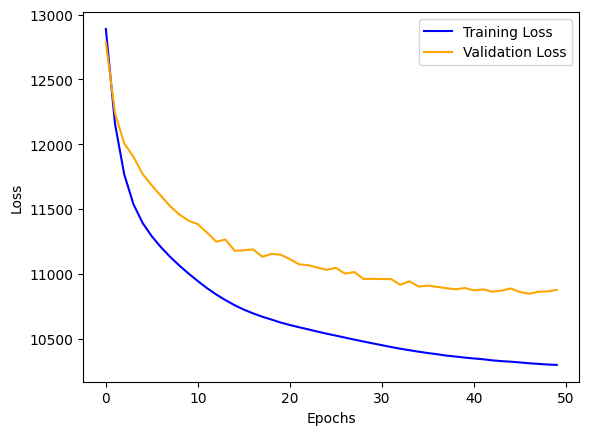

In [33]:
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test with Real Data

In [34]:
test_df = pd.read_csv('./B01_TransformData_FinalAvatar_20230922_171230.csv').iloc[300:-100]

In [35]:
test_df.head()

,Frame,Time,m_avg_PelvisPosX,m_avg_PelvisPosY,m_avg_PelvisPosZ,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipPosX,m_avg_L_HipPosY,...,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristPosX,m_avg_R_WristPosY,m_avg_R_WristPosZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ,Unnamed: 128
300,301,3.516298,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,351.9312,358.1726,282.4885,0.484731,0.254242,1.712456,339.4850,296.8258,305.4126,NaN
301,302,3.527282,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,350.7178,357.2758,281.4112,0.473791,0.253382,1.724783,337.8150,292.9910,307.2033,NaN
302,303,3.538654,0.167637,0.309281,1.707612,357.083,356.5699,359.1780,0.110527,0.229474,...,349.4878,356.3683,280.3726,0.462770,0.253029,1.736980,336.0336,289.2522,308.9090,NaN
303,304,3.549650,0.169145,0.316027,1.705714,357.288,355.9712,359.2451,0.112322,0.236200,...,348.2825,355.5042,279.3825,0.452501,0.258765,1.747534,334.1286,285.3405,310.8063,NaN
304,305,3.561161,0.169145,0.316027,1.705714,357.288,355.9712,359.2451,0.112322,0.236200,...,346.9774,354.4922,278.4650,0.441532,0.259532,1.759929,332.4753,281.4930,312.3235,NaN


In [36]:
test_rotation_columns = [col for col in test_df.columns if 'Rot' in col]
test_rotation_df = test_df[test_rotation_columns]

In [37]:
test_rotation_df

,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipRotX,m_avg_L_HipRotY,m_avg_L_HipRotZ,m_avg_L_KneeRotX,m_avg_L_KneeRotY,m_avg_L_KneeRotZ,m_avg_L_AnkleRotX,...,m_avg_R_CollarRotZ,m_avg_R_ShoulderRotX,m_avg_R_ShoulderRotY,m_avg_R_ShoulderRotZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
300,357.083000,356.5699,359.1780,3.120952,2.614980,1.605597,357.2850,2.783687,0.762435,354.665700,...,350.0468,346.61580,356.47380,287.389800,351.93120,358.17260,282.488500,339.4850,296.8258,305.41260
301,357.083000,356.5699,359.1780,3.120952,2.614980,1.605597,357.2850,2.783687,0.762435,354.665700,...,350.0468,345.37230,355.67140,286.328600,350.71780,357.27580,281.411200,337.8150,292.9910,307.20330
302,357.083000,356.5699,359.1780,3.120952,2.614980,1.605597,357.2850,2.783687,0.762435,354.665700,...,350.0468,344.11480,354.85520,285.303200,349.48780,356.36830,280.372600,336.0336,289.2522,308.90900
303,357.288000,355.9712,359.2451,1.685574,5.019152,2.186052,356.7885,5.105362,1.477256,4.062734,...,349.6448,342.88500,354.07880,284.322500,348.28250,355.50420,279.382500,334.1286,285.3405,310.80630
304,357.288000,355.9712,359.2451,1.685574,5.019152,2.186052,356.7885,5.105362,1.477256,4.062734,...,349.6448,341.55870,353.14730,283.414800,346.97740,354.49220,278.465000,332.4753,281.4930,312.32350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,0.638496,355.0141,356.6961,357.393600,4.837928,3.512594,349.2009,4.826385,2.328943,349.104800,...,353.4269,10.94913,21.90927,6.278744,10.26911,27.53492,2.730536,355.6536,355.0251,20.78619
4672,0.638496,355.0141,356.6961,357.393600,4.837928,3.512594,349.2009,4.826385,2.328943,349.104800,...,353.4269,10.96714,21.80633,6.167922,10.29771,27.43369,2.622310,355.6207,354.8966,20.48832
4673,0.638496,355.0141,356.6961,357.393600,4.837928,3.512594,349.2009,4.826385,2.328943,349.104800,...,353.4269,10.97428,21.70186,6.112121,10.31019,27.33001,2.567600,355.6002,354.7376,20.17733
4674,0.646919,355.0108,356.7127,357.546200,5.342571,3.862668,349.4238,5.280097,2.694932,349.240000,...,353.2370,10.99195,21.59484,6.029818,10.33570,27.22439,2.487622,355.6598,354.5097,19.92392


In [38]:
#-180~180 사이로 정규화
def normalize_angle(x):
    x = np.where(x > 180, x - 360, x)
    x = np.where(x < -180, x + 360, x)
    return x
test_df[test_rotation_columns] = test_df[test_rotation_columns].apply(normalize_angle)

In [39]:
test_df = test_df[test_rotation_columns].map(lambda x: float(f"{x:.2f}") if isinstance(x, (int, float)) else x)

In [40]:
test_df

,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipRotX,m_avg_L_HipRotY,m_avg_L_HipRotZ,m_avg_L_KneeRotX,m_avg_L_KneeRotY,m_avg_L_KneeRotZ,m_avg_L_AnkleRotX,...,m_avg_R_CollarRotZ,m_avg_R_ShoulderRotX,m_avg_R_ShoulderRotY,m_avg_R_ShoulderRotZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
300,-2.92,-3.43,-0.82,3.12,2.61,1.61,-2.71,2.78,0.76,-5.33,...,-9.95,-13.38,-3.53,-72.61,-8.07,-1.83,-77.51,-20.51,-63.17,-54.59
301,-2.92,-3.43,-0.82,3.12,2.61,1.61,-2.71,2.78,0.76,-5.33,...,-9.95,-14.63,-4.33,-73.67,-9.28,-2.72,-78.59,-22.19,-67.01,-52.80
302,-2.92,-3.43,-0.82,3.12,2.61,1.61,-2.71,2.78,0.76,-5.33,...,-9.95,-15.89,-5.14,-74.70,-10.51,-3.63,-79.63,-23.97,-70.75,-51.09
303,-2.71,-4.03,-0.75,1.69,5.02,2.19,-3.21,5.11,1.48,4.06,...,-10.36,-17.12,-5.92,-75.68,-11.72,-4.50,-80.62,-25.87,-74.66,-49.19
304,-2.71,-4.03,-0.75,1.69,5.02,2.19,-3.21,5.11,1.48,4.06,...,-10.36,-18.44,-6.85,-76.59,-13.02,-5.51,-81.54,-27.52,-78.51,-47.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,0.64,-4.99,-3.30,-2.61,4.84,3.51,-10.80,4.83,2.33,-10.90,...,-6.57,10.95,21.91,6.28,10.27,27.53,2.73,-4.35,-4.97,20.79
4672,0.64,-4.99,-3.30,-2.61,4.84,3.51,-10.80,4.83,2.33,-10.90,...,-6.57,10.97,21.81,6.17,10.30,27.43,2.62,-4.38,-5.10,20.49
4673,0.64,-4.99,-3.30,-2.61,4.84,3.51,-10.80,4.83,2.33,-10.90,...,-6.57,10.97,21.70,6.11,10.31,27.33,2.57,-4.40,-5.26,20.18
4674,0.65,-4.99,-3.29,-2.45,5.34,3.86,-10.58,5.28,2.69,-10.76,...,-6.76,10.99,21.59,6.03,10.34,27.22,2.49,-4.34,-5.49,19.92


In [41]:
# -180 ~ 180 범위를 벗어나는 값이 있는지 확인
num_values_out_of_range = (test_df > 180).sum().sum() + (test_df < -180).sum().sum()

# 결과 확인
if num_values_out_of_range > 0:
    print(f"범위를 벗어나는 값의 수: {num_values_out_of_range}")
else:
    print("범위를 벗어나는 값이 없습니다.")

범위를 벗어나는 값이 없습니다.


In [42]:
test_df.shape

(4376, 63)

In [43]:
# 결과를 새로운 CSV 파일로 저장합니다.
test_df.to_csv('./test_df.csv', index=False)

In [48]:
# 모델을 평가 모드로 설정
model.eval()

# 예측 값을 넣을 빈 리스트
test_predictions = []

# 훈련 데이터셋에서 마지막 입력 개수의 값을 가져온 후
current_batch = torch.from_numpy(test_df[-n_input:].values.astype(np.float32)).reshape((1, n_input, n_features))

# 모델이 사용하는 디바이스를 확인하고 데이터를 해당 디바이스로 옮깁니다.
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
current_batch = current_batch.to(current_device)

# 예측 과정 반복
with torch.no_grad():  # 그래디언트 계산을 비활성화
    for i in range(1):
        # 현재 배치에서 다음 포인트를 예측
        current_pred = model(current_batch).cpu().numpy()[0]  # 마지막 시퀀스 포인트 예측
        current_pred = np.array([normalize_angle(y) for y in current_pred])  # 예측값 정규화

        # 예측된 마지막 프레임을 리스트에 추가
        test_predictions.append(current_pred)

        # 새로운 배치 생성: 마지막 시퀀스 제외하고 예측값 추가
        current_batch = np.roll(current_batch.cpu().numpy(), -1, axis=1)
        current_batch[:, -1, :] = current_pred
        current_batch = torch.from_numpy(current_batch).to(current_device)

In [49]:
test_predictions

[array([ -8.36271858,   1.52798653,  -1.83110571,  -3.74713039,
         12.55899525,   0.33136725,  -9.40380287,  10.47586155,
          1.12912226,  -2.07923746,  -0.13644487,   1.17281783,
         -1.43221653, -10.75444126,  15.16151237,  -6.55329561,
        -12.99492455,  -1.58172917,  -7.76797438, -13.77939224,
         -2.51179767,  -0.82390171,  13.75622082,  -3.02825952,
          2.84747791,   9.16064453,  -1.314327  ,  -7.43386412,
          1.3347106 ,  -2.05864644,  -0.15528074,   4.75243902,
         -1.83560479,  -2.52064061,   8.74391842,   4.30780983,
         -3.98666906,  23.04104805,  -2.93955469,  -4.88390303,
         16.15159798, -12.23924923,  -6.18827677,  24.94114494,
         17.30404854,  -4.27114582,   4.57458782,  -1.15341043,
          5.21155787,   1.88073635,  -2.44791222,  -3.30967641,
        -11.17351341,  -9.02195168,  -0.69701171, -17.34079552,
         -5.11593199,  -2.41322565,   0.56683505,  -0.31204009,
         -2.93524289, -14.80333996,  21.

In [50]:
test_predictions_array = np.array(test_predictions)

In [51]:
# 변환된 리스트를 데이터프레임으로 변환합니다.
test_predictions = pd.DataFrame(test_predictions_array)

# test_predictions 데이터프레임을 CSV 파일로 저장합니다.
test_predictions.to_csv('./test_predictions.csv', index=True)

In [52]:
test_predictions

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-8.362719,1.527987,-1.831106,-3.74713,12.558995,0.331367,-9.403803,10.475862,1.129122,-2.079237,...,-9.021952,-0.697012,-17.340796,-5.115932,-2.413226,0.566835,-0.31204,-2.935243,-14.80334,21.591707


In [56]:
# input 데이터(test_df)의 마지막 30 프레임과 
last_inputs_df = test_df.iloc[-30:][column_order].reset_index(drop=True)
test_predictions_df = pd.DataFrame(test_predictions_array, columns=column_order)

test_combined_df = pd.concat([last_inputs_df, test_predictions_df], ignore_index=True)

In [57]:
test_combined_df

,m_avg_PelvisRotX,m_avg_PelvisRotY,m_avg_PelvisRotZ,m_avg_L_HipRotX,m_avg_L_HipRotY,m_avg_L_HipRotZ,m_avg_L_KneeRotX,m_avg_L_KneeRotY,m_avg_L_KneeRotZ,m_avg_L_AnkleRotX,...,m_avg_R_CollarRotZ,m_avg_R_ShoulderRotX,m_avg_R_ShoulderRotY,m_avg_R_ShoulderRotZ,m_avg_R_ElbowRotX,m_avg_R_ElbowRotY,m_avg_R_ElbowRotZ,m_avg_R_WristRotX,m_avg_R_WristRotY,m_avg_R_WristRotZ
0,1.290000,-2.860000,-1.520000,-2.88000,9.890000,4.190000,-19.270000,9.840000,1.820000,-23.310000,...,-22.950000,10.220000,25.170000,9.440000,9.240000,30.740000,5.80000,-1.590000,-1.08000,28.350000
1,-10.840000,-133.450000,-3.480000,-10.59000,-83.650000,19.510000,-38.960000,-92.770000,19.100000,-37.730000,...,-9.760000,10.190000,25.240000,9.640000,9.190000,30.800000,5.99000,-1.950000,-1.22000,28.450000
2,-10.840000,-133.450000,-3.480000,-10.59000,-83.650000,19.510000,-38.960000,-92.770000,19.100000,-37.730000,...,-9.760000,10.210000,25.230000,9.700000,9.200000,30.790000,6.05000,-2.250000,-1.39000,28.470000
3,-10.840000,-133.450000,-3.480000,-10.59000,-83.650000,19.510000,-38.960000,-92.770000,19.100000,-37.730000,...,-9.760000,10.220000,25.190000,9.740000,9.210000,30.750000,6.09000,-2.550000,-1.55000,28.440000
4,1.070000,-4.730000,-2.910000,-1.37000,2.790000,3.020000,-20.960000,3.240000,0.080000,-21.270000,...,-17.430000,10.250000,25.120000,9.710000,9.240000,30.680000,6.06000,-2.900000,-1.71000,28.450000
5,1.070000,-4.730000,-2.910000,-1.37000,2.790000,3.020000,-20.960000,3.240000,0.080000,-21.270000,...,-17.430000,10.270000,25.040000,9.660000,9.270000,30.600000,6.02000,-3.260000,-1.87000,28.500000
6,1.070000,-4.730000,-2.910000,-1.37000,2.790000,3.020000,-20.960000,3.240000,0.080000,-21.270000,...,-17.430000,10.300000,24.950000,9.570000,9.310000,30.510000,5.94000,-3.590000,-2.08000,28.500000
7,0.830000,-4.650000,-3.010000,-1.52000,3.960000,2.810000,-17.180000,4.290000,0.480000,-13.930000,...,-12.610000,10.350000,24.770000,9.400000,9.370000,30.330000,5.77000,-3.910000,-2.33000,28.320000
8,0.830000,-4.650000,-3.010000,-1.52000,3.960000,2.810000,-17.180000,4.290000,0.480000,-13.930000,...,-12.610000,10.400000,24.610000,9.230000,9.440000,30.180000,5.61000,-4.220000,-2.60000,27.990000
9,0.830000,-4.650000,-3.010000,-1.52000,3.960000,2.810000,-17.180000,4.290000,0.480000,-13.930000,...,-12.610000,10.440000,24.460000,9.050000,9.500000,30.030000,5.43000,-4.470000,-2.94000,27.070000


In [58]:
test_combined_df.to_csv('./test_combined_df.csv', index=True)